In [49]:
import pandas as pd
import re
from pandas import DataFrame
import jieba
import matplotlib.pyplot as plt
import gensim
import gensim.models.word2vec as w2v
from gensim.corpora.dictionary import Dictionary
import torch.nn as nn
import torch.utils.data as Data
import torch
import numpy as np
filepath="train.csv" #打开训练文件，要放在当前目录下
algo=pd.read_csv(filepath)
filepath="test_with_class.csv" #打开测试文件，要放在当前目录下.这里我为了和模型兼容，为test增加一栏目lable，并且全部设为0，不参与模型运算，因此不会造成影响
algo_test=pd.read_csv(filepath)

In [50]:
#测试栏，与算法无关
voc_list = []
for line in algo['text']:
    cop = re.compile("[^\u4e00-\u9fa5^\s]") # 去除非中英文字、数字的所有字符
    line = cop.sub('', line)# 去除非中英文字、数字的所有字符
    vocs = jieba.lcut(line)  #voc变成了一个数组存放词
    for voc in vocs:
        voc_list.append(voc)   #把vocs分好词之后的每一个词放入voc_list
#print(voc_list)
    
    

全部数据词总数为： 148800 ; 每条数据的平均词数为： 24.70939887080704


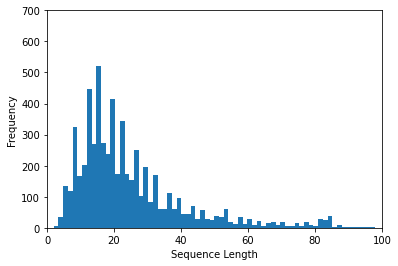

In [51]:
def analyse_word_num(data): #描述统计
    data_num_train = len(data['text']) # 数据条数
    word_num = 0 # 总词数
    single_num = [] # 每条数据的长度的大小数组
    ave_num = 0 # 平均每条数据的词数大小

    for i in range(len(data['text'])):
        single_num.append(len(data['text'][i]))
        word_num += len(data['text'][i])
    ave_num = word_num/data_num_train
    print('全部数据词总数为：',word_num,'; 每条数据的平均词数为：' ,ave_num)
    
    %matplotlib inline
    plt.hist(single_num, bins=100)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.axis([0,100,0,700])
    plt.show()
    
analyse_word_num(algo)



In [52]:
def splite_content(data): 
    string_splite = ''
    pure_data = []
    for temp in range(len(data['text'])):
        content = data['text'][temp]
        new_content = jieba.cut(content,cut_all=False)
        str_out = ' '.join(new_content)
        cop = re.compile("[^\u4e00-\u9fa5^\s]") # 去除非中英文字、数字的所有字符
        str_out = cop.sub('', str_out)

        for i in range(6):
            str_out = str_out.replace('  ',' ') #去除多余空格
        str_out = str_out.strip() # 去除两边空格

        data['text'][temp] = str_out.split(' ')
        pure_data.append([data['text'][temp],data['class'][temp]])
        str_out += '\r\n' 
        string_splite += str_out
    return pure_data, string_splite   #pure_data代表句子分词后和标签的配对，string_splite代表每个句子的分词

filepath="train.csv" #打开训练文件，要放在当前目录下
algo=pd.read_csv(filepath) #重新导入数据

filepath="test_with_class.csv" #打开测试文件,我自己添加了标签，全为0，要放在当前目录下
algo_test=pd.read_csv(filepath) #重新导入数据

splite_word_all = '' #利用这个保存test和train的所有分词和分类

sentence_dis_class_train, sentence_dis_train = splite_content(algo)    #注意该语句只能执行一次，否则第二次执行是再分好词的基础上，会报错，要想重新执行就要重新导入数据
sentence_dis_class_test, sentence_dis_test = splite_content(algo_test)
splite_word_all += sentence_dis_train + sentence_dis_test

f = open('splite_word_all.txt', 'w', encoding='utf-8')
f.write(splite_word_all)
f.close()

C:\Users\cs-demo\AppData\Local\Temp/ipykernel_14908/2660944286.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'][temp] = str_out.split(' ')


In [53]:
#模型训练，生成词向量
model_file_name = 'classification_model.txt'  #利用gensim生成模型
sentences = w2v.LineSentence('splite_word_all.txt')
model = w2v.Word2Vec(sentences, vector_size=32, window=20, min_count=3, workers=4) # 参数含义：数据源，生成词向量长度，时间窗大小，最小词频数，线程数
model.save(model_file_name)

In [54]:
# 使用训练好的模型
model = w2v.Word2Vec.load(model_file_name)


# 创建词语字典
def create_dictionaries(p_model):
    gensim_dict = Dictionary()
    gensim_dict.doc2bow(p_model.wv.index_to_key, allow_update=True)
    w2indx = {v: k  for k, v in gensim_dict.items()}  # 词语的索引，从0开始编号
    id2vec = {w2indx.get(word): model.wv.__getitem__(word) for word in w2indx.keys()}  # 词语的词向量
    return w2indx, id2vec

word_id_dic, id_vect_dic= create_dictionaries(model) # 两个词典的功能：word-> id , id -> vector


In [55]:
# token化数据，word->id
def get_tokenized_imdb(data):
    """
    data: list of [list of word , label]
    
    """
    for word_list, label in data:
        temp = []
        for word in word_list:
            if(word in word_id_dic.keys()):
                temp.append(int(word_id_dic[word]))
            else:
                temp.append(0)
        yield [temp,label]


In [56]:
# 对数据进行 截断 和 填充
def preprocess_imdb(data):
    max_l = 30  # 将每条微博通过截断或者补1，使得长度变成30

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [1] * (max_l - len(x))

    features = torch.tensor([pad(content[0]) for content in data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

data_train = preprocess_imdb(list(get_tokenized_imdb(sentence_dis_class_train)))
data_test = preprocess_imdb(list(get_tokenized_imdb(sentence_dis_class_test)))

# 加载数据到迭代器，并规定batch 大小
batch_size = 64 #代表一共有64个batch
train_set = Data.TensorDataset(*data_train)  # *表示接受元组类型数组 ，因为data_train={feature,lable}，所以要传递数组*
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
for x,y in train_iter:
    print(x)
    print(y)
test_set = Data.TensorDataset(*data_test)  # *表示接受元组类型数组
test_iter = Data.DataLoader(test_set, batch_size, shuffle=True)



tensor([[2125,  174, 1517,  ...,    1,    1,    1],
        [1478, 2156,  274,  ..., 2621,  976,    1],
        [1590,  441, 1781,  ...,    1,    1,    1],
        ...,
        [2569, 2300,  187,  ...,    1,    1,    1],
        [ 361, 1261, 1237,  ...,    1,    1,    1],
        [ 356, 2626, 2685,  ...,    1,    1,    1]])
tensor([0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2])
tensor([[1590, 1191, 2156,  ...,    1,    1,    1],
        [2398, 1292, 2863,  ...,    1,    1,    1],
        [1620,  340, 2383,  ...,    1,    1,    1],
        ...,
        [1478, 2156, 2436,  ...,    1,    1,    1],
        [2661, 1154,  274,  ...,    1,    1,    1],
        [2445,  451,  876,  ...,    1,    1,    1]])
tensor([2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [57]:
class BiRNN(nn.Module):
    def __init__(self, vocab_num, embed_size, num_hiddens, num_layers):
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_num, embed_size)
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=embed_size, 
                                hidden_size=num_hiddens, 
                                num_layers=num_layers,
                                bidirectional=True)
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.decoder = nn.Linear(4*num_hiddens, 6)

    def forward(self, inputs):
        # inputs的形状是(批量大小, 词数)，因为LSTM需要将序列长度(seq_len)作为第一维，所以将输入转置后
        # 再提取词特征，输出形状为(词数, 批量大小, 词向量维度)
        embeddings = self.embedding(inputs.permute(1, 0))
        # rnn.LSTM只传入输入embeddings，因此只返回最后一层的隐藏层在各时间步的隐藏状态。
        # outputs形状是(词数, 批量大小, 2 * 隐藏单元个数)
        outputs, _ = self.encoder(embeddings) # output, (h, c)
        # 连结初始时间步和最终时间步的隐藏状态作为全连接层输入。它的形状为
        # (批量大小, 4 * 隐藏单元个数)。
        encoding = torch.cat((outputs[0], outputs[-1]), -1)
        outs = self.decoder(encoding)
        return outs

vocab_num = len(model.wv.index_to_key)
embed_size, num_hiddens, num_layers = 32, 60, 2
net = BiRNN(vocab_num, embed_size, num_hiddens, num_layers)


In [58]:
id_vect = torch.Tensor(list(id_vect_dic.values()))
net.embedding.weight.data.copy_(id_vect)
net.embedding.weight.requires_grad = False # 直接加载预训练好的, 所以不需要更新它


In [59]:
lr, num_epochs = 0.001, 50   #学习率
# 要过滤掉不计算梯度的embedding参数
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [60]:
# 训练函数
def train(train_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    train_ls= []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y) 
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
            
        train_ls.append(train_l_sum / n)  
        if((epoch+1)%5 == 0):
            print('epoch %d, loss %.4f, train acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n,  time.time() - start)) 
    loss_plot(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', ['train'])



In [61]:
# 定义绘图函数
def loss_plot(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.plot(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)



training on  cuda
epoch 5, loss 0.1001, train acc 0.856, time 1.0 sec
epoch 10, loss 0.0503, train acc 0.856, time 1.0 sec
epoch 15, loss 0.0330, train acc 0.856, time 0.9 sec
epoch 20, loss 0.0246, train acc 0.856, time 0.9 sec
epoch 25, loss 0.0198, train acc 0.856, time 0.9 sec
epoch 30, loss 0.0162, train acc 0.856, time 0.9 sec
epoch 35, loss 0.0137, train acc 0.856, time 0.9 sec
epoch 40, loss 0.0123, train acc 0.856, time 0.9 sec
epoch 45, loss 0.0106, train acc 0.856, time 0.9 sec
epoch 50, loss 0.0096, train acc 0.856, time 0.9 sec


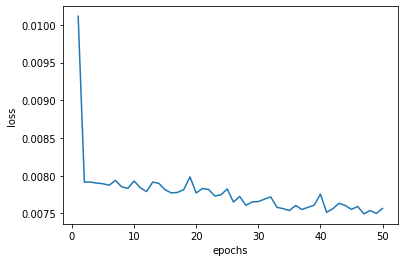

In [62]:
import time
train(train_iter, net, loss, optimizer, device, 50)


In [63]:
# 预测函数
def predict(data_iter, net, device=None):
    
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    file_classify_out = open('output_classification.txt','w',encoding='utf8')
    net.eval() # 评估模式, 这会关闭dropout
    with torch.no_grad():
        count=0
        y_hats = ''
        for X, y in data_iter:
            y_hat = net(X.to(device)).argmax(dim=1)
            y_hat = str(y_hat)  #将tensor转换为字符串形式
            y_hat = y_hat.strip('device=\'cuda:0\')tensor')  #\' 表示字符串里的',要打转义字符
            y_hat = re.sub('[()]', '', y_hat)#去除其他括号字符
            #y_hat = y_hat.replace(',', '')#去除逗号
            y_hat = y_hat.replace(' ', '')#去除空格
            y_hat = y_hat.replace('\n', '')
            y_hat = y_hat.replace('[', '')
            y_hat = y_hat.replace(']', '')
            y_hat = y_hat.replace(',', ' ')
            y_hats+=y_hat
    y_hats = y_hats.split()
    file_classify_out.write(str(y_hats))
    file_classify_out.close()
    return



In [64]:
predict(test_iter, net, device=None) #输出output_classfication文件，存放预测结果

In [65]:
file0=open('output_classification.txt','r')
lable=eval(file0.read())  #情感分类的文件